### Import Neccessary Libraries

In [12]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves
from pathlib import Path
from helper_functions import pred_and_plot_image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
image_path = Path("data/pizza_steak_sushi_20_percent")
train_dir = image_path / "train"
test_dir = image_path / "test"

### Prepare Dataset

In [4]:
# image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"manually created transforms: {manual_transforms}")

manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2d66e145de0>,
 ['pizza', 'steak', 'sushi'])

#### Visualize a single image

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

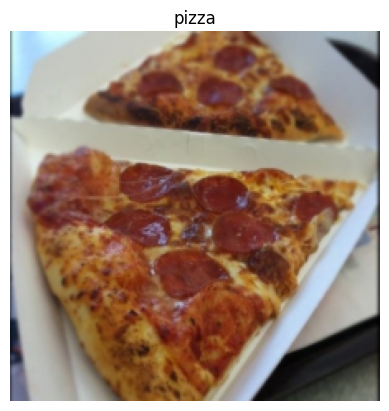

In [10]:
# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

Following the ViT research paper   
Recall:
* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [7]:
# Create example values
height = 224  # H ("The training resolution is 224.")
width = 224  # W
color_channels = 3  # C
patch_size = 16  # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(
    f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [9]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (
    number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(
    f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Lets visualize what it looks like to turn our input image into patches

(-0.5, 223.5, 223.5, -0.5)

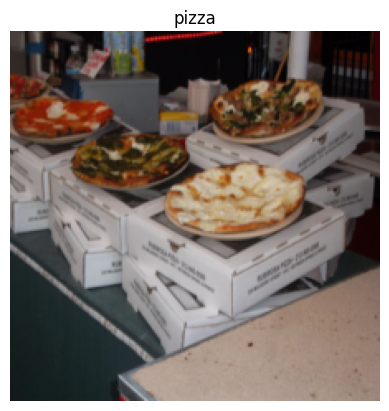

In [8]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

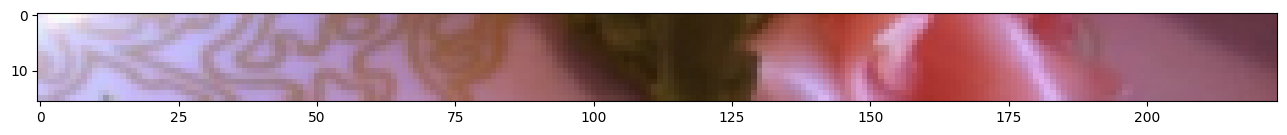

In [11]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


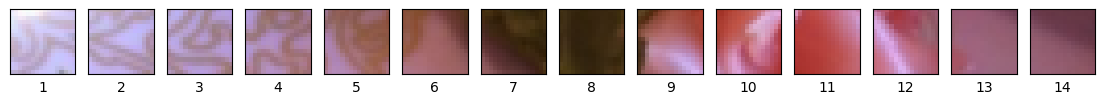

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(
    f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,  # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    # keep height index constant, alter the width index
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)  # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Visualizing the Patch of the Whole Image

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


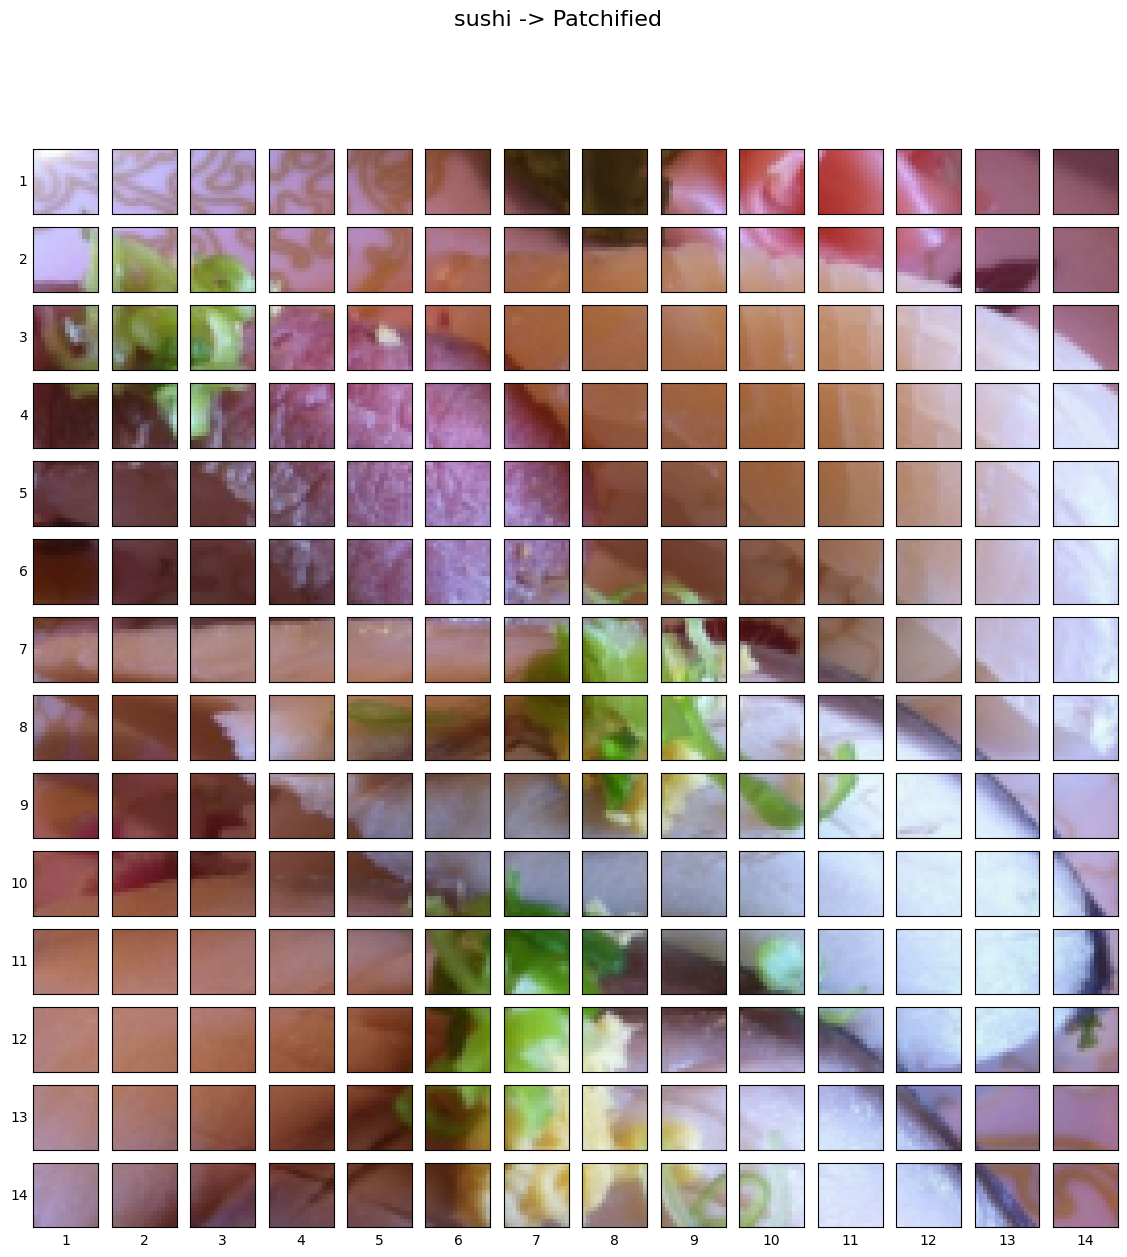

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,  # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
# iterate through height
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    # iterate through width
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # iterate through height
                                        patch_width:patch_width+patch_size,  # iterate through width
                                        :])  # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Replicating the Model from the ViT research Paper

In [8]:
# Create the Conv2d layer with hyperparameters from the ViT paper
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,  # number of color channels
                   out_channels=768,  # from Table 1: Hidden size D, this is the embedding size
                   # could also use (patch_size, patch_size)
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [15]:
# Pass the image through the convolutional layer
# add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


#### Visualizing 5 random feature maps

Showing random convolutional feature maps from indexes: [283, 479, 498, 14, 456]


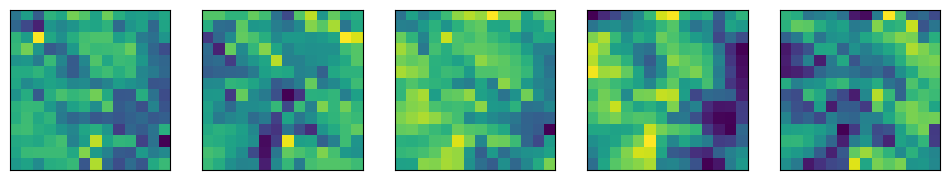

In [16]:
# Plot random 5 convolutional feature maps
import random
# pick 5 numbers between 0 and the embedding size
random_indexes = random.sample(range(0, 758), k=5)
print(
    f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    # index on the output tensor of the convolutional layer
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [14]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 1.2414e-02,  1.6008e-01, -4.3702e-02, -1.6359e-01,  8.7238e-02,
           -9.0077e-03, -5.1486e-02,  9.1123e-02,  3.3111e-03, -6.0602e-02,
            1.0621e-01,  6.4887e-02, -1.5055e-02,  8.8542e-03],
          [ 7.0541e-03,  9.5201e-03,  7.4229e-02,  5.6939e-02,  3.1683e-03,
           -1.5042e-01, -2.6263e-02, -1.7069e-01, -1.7694e-02, -2.8911e-02,
            1.0845e-01,  9.7900e-02,  1.2140e-02,  1.5268e-02],
          [ 8.1736e-04,  8.3912e-02,  4.3405e-02,  6.8959e-02,  8.2008e-03,
            2.6731e-02, -8.6485e-02,  3.5655e-02, -4.4062e-03,  1.6118e-01,
            2.1520e-01,  2.6419e-01, -1.8937e-01, -1.3033e-01],
          [ 1.0229e-01,  1.2910e-01,  2.2157e-01,  1.5230e-02,  1.2530e-01,
            1.5271e-01,  2.3896e-02, -6.6617e-03,  4.0618e-02,  1.2694e-02,
           -4.9133e-02,  5.1059e-03, -2.5855e-02,  1.7969e-02],
          [ 1.8627e-02, -2.1876e-01,  3.4837e-02,  2.0985e-01, -4.7761e-02,
            1.2679e-01,  5.3155e-02,  3.9954e-02, -3.1593e-0

It has a truthy required grad property, which means its gradient can be updated by gradient descent during training. Therefore, it is considered a learnable embedding

In [17]:
# Current tensor shape
print(
    f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


We do want to flatten the feature map height and its width to be 1x1 because the ViT research paper said the spatial dimensions of the feature map has to be flattened before projecting it to the transformer dimension

In [9]:
flatten = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                     end_dim=3)  # flatten feature_map_width (dimension 3)

In [19]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(
    f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


we are getting close, we have one batch of our image in 768,196. But the remember that from the paper, it is 196, 768, so we can permute its shape

In [20]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(
    0, 2, 1)  # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(
    f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

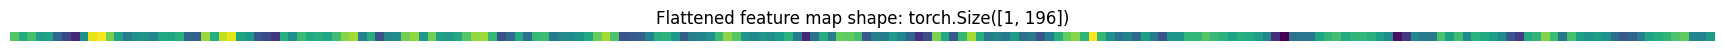

In [21]:
# Get a single flattened feature map
# index: (batch_size, number_of_patches, embedding_dimension)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [22]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.4775, 0.4198, 0.4657, 0.3927, 0.4038, 0.2824, 0.2243, 0.1719, 0.3698,
          0.5938, 0.6059, 0.5068, 0.4047, 0.3246, 0.3685, 0.3738, 0.3458, 0.4145,
          0.4083, 0.4288, 0.2798, 0.2682, 0.5357, 0.4246, 0.5649, 0.5917, 0.4063,
          0.3808, 0.2528, 0.2278, 0.1939, 0.4261, 0.3654, 0.4526, 0.4179, 0.4248,
          0.4063, 0.4584, 0.5214, 0.5426, 0.3390, 0.4242, 0.2423, 0.3451, 0.3584,
          0.5080, 0.5300, 0.3837, 0.5062, 0.3958, 0.3899, 0.4149, 0.4790, 0.5306,
          0.5397, 0.4483, 0.2418, 0.2883, 0.4222, 0.3035, 0.4468, 0.4542, 0.3169,
          0.3489, 0.3554, 0.3719, 0.4185, 0.4956, 0.5432, 0.4726, 0.2440, 0.2574,
          0.2695, 0.3380, 0.4265, 0.4357, 0.3792, 0.2653, 0.3274, 0.3380, 0.3691,
          0.4540, 0.5238, 0.4829, 0.3753, 0.3487, 0.3742, 0.3590, 0.3943, 0.4325,
          0.3206, 0.1707, 0.2983, 0.4243, 0.3276, 0.4932, 0.4897, 0.4661, 0.2534,
          0.3310, 0.3197, 0.3851, 0.3428, 0.2824, 0.1869, 0.2330, 0.5121, 0.4146,
          0.2609

### Creating The ViT Model Patch Enbedding Layer

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=3, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    
    def forward(self, x: torch.Tensor):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0,2,1)

we can try out our patch embedding block on a single image

In [11]:
set_seeds()
patchify = PatchEmbedding()

In [36]:
# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
# add an extra batch dimension on the 0th index, otherwise will error
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [37]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(
    f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.7911,  0.2397, -0.1761,  ...,  0.6202, -0.4194,  0.2410],
         [-0.7466,  0.1567, -0.1613,  ...,  0.5515, -0.3389,  0.1594],
         [-0.6081,  0.1193, -0.1819,  ...,  0.4991, -0.3095,  0.2653],
         ...,
         [-0.8356,  0.0744, -0.3182,  ...,  0.6564, -0.2672,  0.3292],
         [-0.4185, -0.0051, -0.2284,  ...,  0.3090, -0.1750,  0.2310],
         [-0.5363,  0.1014, -0.2067,  ...,  0.3729, -0.2072,  0.1665]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


We have to prepend a learnable embedding of the image class to the first index of the patch embedding

In [38]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),  # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True)  # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(
    f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [39]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)  # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(
    f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7911,  0.2397, -0.1761,  ...,  0.6202, -0.4194,  0.2410],
         [-0.7466,  0.1567, -0.1613,  ...,  0.5515, -0.3389,  0.1594],
         ...,
         [-0.8356,  0.0744, -0.3182,  ...,  0.6564, -0.2672,  0.3292],
         [-0.4185, -0.0051, -0.2284,  ...,  0.3090, -0.1750,  0.2310],
         [-0.5363,  0.1014, -0.2067,  ...,  0.3729, -0.2072,  0.1665]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [51]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)  # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(
    f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [53]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(
    f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.2089, 1.2397, 0.8239,  ..., 1.6202, 0.5806, 1.2410],
         [0.2534, 1.1567, 0.8387,  ..., 1.5515, 0.6611, 1.1594],
         ...,
         [0.1644, 1.0744, 0.6818,  ..., 1.6564, 0.7328, 1.3292],
         [0.5815, 0.9949, 0.7716,  ..., 1.3090, 0.8250, 1.2310],
         [0.4637, 1.1014, 0.7933,  ..., 1.3729, 0.7928, 1.1665]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Multihead Self Attention Block

In [12]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        x, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return x

In [13]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock()

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(
    patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}", patch_and_position_embedding[:,:,0])
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}", patched_image_through_msa_block[:, :,0])

NameError: name 'patch_and_position_embedding' is not defined

### Multi Layer Perceptron Block
it composes of two linear layers, each followed by dropout layer, but the first has a non linear layer before the dropout layer

In [14]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, mlp_size:int=3072, dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

### Adding up the MSA and MLP to create our Transformer Encoder

In [15]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, mlp_size:int=3072, mlp_dropout:float=0.1, attn_dropout:float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

visualizing our transformer encoder summary

In [16]:
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### Looks GOOD!   
But we can simply this by using the nn.transformerEncoderLayer and input our kwargs***

In [17]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation='gelu', batch_first=True, norm_first=True)

In [75]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [18]:
summary(model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

advantages of using the pytorch built in layers is that: they are less prone to error and they have better performance

with all the previously highlighted model blocks/layers, we can now proceed to put them all together by so, create our full ViT model.

### ViT Model

In [45]:
class ViT(nn.Module):
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self, img_size:int=224, in_channels:int=3, patch_size: int=16, num_transformer_layers:int=12, embedding_dim:int=768, mlp_size:int=3072, num_heads:int=12, attn_dropout:float=0, mlp_dropout:float=0.1, embedding_dropout:float=0.1, num_classes:int=1000):
        super().__init__()

        # ensure the image size is divisible by the path size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        #  Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size*img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim), requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

        # Create transformer encoder block (we can stack multiple TEBs using nn.sequential()), the * means all
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (eq 1)
        class_token = self.class_embedding.expand(batch_size,-1,-1)

        # create patch embedding (eq 1)
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding
        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        # Pass the patch, position and class embedding through the transformer encoder blocks (eq 2 & 3)
        x = self.transformer_encoder(x)

        # Put o index logit through the classifier (eq 4) the 0 index holds the class embedding
        x = self.classifier(x[:, 0])

        return x

In [43]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(
    1, 1, 768))  # create a single learnable class token
# expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"
class_token_embedding_expanded = class_token_embedding_single.expand(
    batch_size, -1, -1)

print(
    f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(
    f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [51]:
set_seeds()

# Create a random tensor with same shape as a single image
# (batch_size, color_channels, height, width)
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [49]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

Using the value of the optimizer as mentioned in the ViT paper

In [50]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9,0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9058 | train_acc: 0.2031 | test_loss: 3.1816 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.1737 | train_acc: 0.2773 | test_loss: 3.8516 | test_acc: 0.2604


KeyboardInterrupt: 

In [ ]:
plot_loss_curves(results)

clearly, our model is underfitting and we can expect that because the ViT performed excpetionally on larger datasets and other hyperparameter we reduced because of our computing power

### Using a Pretrained ViT Model

In [4]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to('cpu')

In [11]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [5]:
auto_transforms = pretrained_vit_weights.transforms()

In [6]:
for params in pretrained_vit.conv_proj.parameters():
    params.requires_grad = False

In [7]:
for params in pretrained_vit.encoder.parameters():
    params.requires_grad = False

In [8]:
pretrained_vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
)

In [25]:
summary(model=pretrained_vit,
        # (batch_size, num_patches, embedding_dimension)
        input_size=(1,3,224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [9]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15d879ea0e0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
results = engine.train(model=pretrained_vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=1, device='cpu')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4704 | train_acc: 0.8458 | test_loss: 0.0863 | test_acc: 0.9750


wow, 97% accuracy, if we train for 100 epochs imagine what it will become, lets not even talk of training for 1000 epochs

### Predicting with our Model

In [27]:
img_path = Path("data/04-pizza-dad.jpeg")

In [23]:
from PIL import Image

Converted image from webp to jpg

In [17]:
im = Image.open(img_path).convert('RGB')

In [21]:
im.save('data/pizza.jpg', 'jpeg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


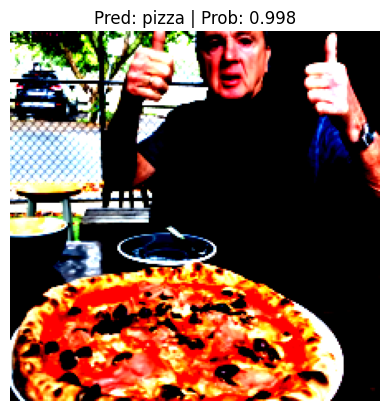

In [29]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=img_path,
                    class_names=class_names, transform=auto_transforms, device='cpu')

Oh nooo! 99.999% pizza